# Gemini API: Read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.


## Setup

### Install the Google GenAI SDK

Install the Google GenAI SDK from [npm](https://www.npmjs.com/package/@google/genai). 

```bash
$ npm install @google/genai
```

### Setup your API key

You can [create](https://aistudio.google.com/app/apikey) your API key using Google AI Studio with a single click.

Remember to treat your API key like a password. Don't accidentally save it in a notebook or source file you later commit to GitHub. In this notebook we will be storing the API key in a `.env` file. You can also set it as an environment variable or use a secret manager. 

Here's how to set it up in a `.env` file:

```bash
$ touch .env
$ echo "GEMINI_API_KEY=<YOUR_API_KEY>" >> .env
```

:::{.callout-tip}

Another option is to set the API key as an environment variable. You can do this in your terminal with the following command:

```bash
$ export GEMINI_API_KEY="<YOUR_API_KEY>"
```
:::

### Load the API key

To load the API key from the `.env` file, we will use the `dotenv` package. This package loads environment variables from a `.env` file into `process.env`. 

```bash
$ npm install dotenv
```

Then, we can load the API key in our code:


In [2]:
const dotenv = require("dotenv") as typeof import("dotenv");

dotenv.config({
  path: "../.env",
});

const GEMINI_API_KEY = process.env.GEMINI_API_KEY ?? "";
if (!GEMINI_API_KEY) {
  throw new Error("GEMINI_API_KEY is not set in the environment variables");
}
console.log("GEMINI_API_KEY is set in the environment variables");


GEMINI_API_KEY is set in the environment variables


:::{.callout-note}
In our particular case the `.env` is is one directory up from the notebook, hence we need to use `../` to go up one directory. If the `.env` file is in the same directory as the notebook, you can omit it altogether. 

```
│
├── .env
└── quickstarts
    └── PDF_Files.ipynb
```
:::


### Initialize SDK Client

With the new SDK, now you only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.


In [3]:
const google = require("@google/genai") as typeof import("@google/genai");

const ai = new google.GoogleGenAI({ apiKey: GEMINI_API_KEY });


### Select a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).


In [4]:
const tslab = require("tslab") as typeof import("tslab");

const MODEL_ID = "gemini-2.5-flash-preview-05-20";


## Download and inspect the PDF

This PDF page is an article titled [Smoothly editing material properties of objects with text-to-image models and synthetic data](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) available on the Google Research Blog.


In [5]:
const fs = require("fs") as typeof import("fs");
const path = require("path") as typeof import("path");

const downloadFile = async (url: string, filePath: string) => {
  const response = await fetch(url);
  if (!response.ok) {
    throw new Error(`Failed to download file: ${response.statusText}`);
  }
  const buffer = await response.blob();
  const bufferData = Buffer.from(await buffer.arrayBuffer());
  fs.writeFileSync(filePath, bufferData);
};


In [6]:
const PDF_URL =
  "https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf";

const pdfPath = path.join("../assets", "article.pdf");
await downloadFile(PDF_URL, pdfPath);


Look at one of the pages:


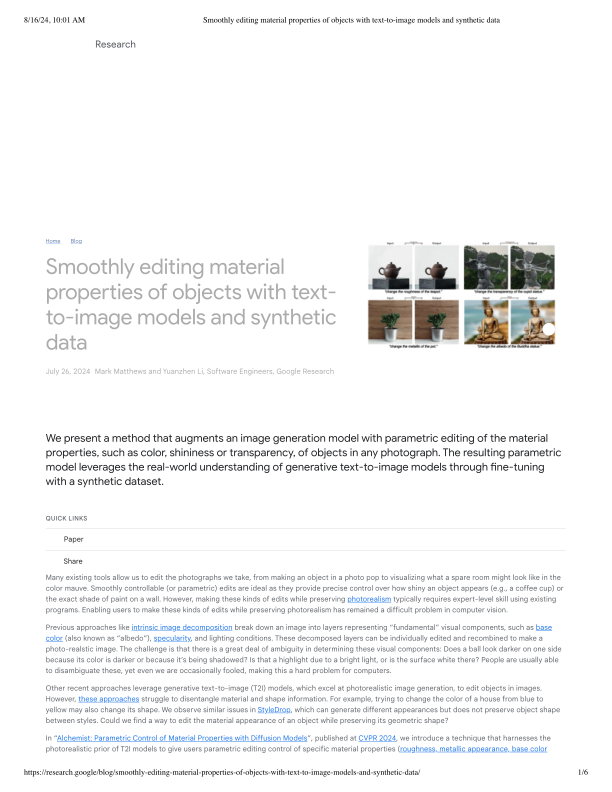

In [7]:
const getPage = async (pdfPath: string, pageNumber: number): Promise<Uint8Array> => {
  const { pdf } = await import("pdf-to-img");
  const document = await pdf(pdfPath);
  let pageIndex = 0;
  for await (const page of document) {
    if (pageIndex === pageNumber) {
      return new Uint8Array(page);
    }
    pageIndex++;
  }
  throw new Error(`Page ${pageNumber} not found in the PDF document.`);
};

tslab.display.png(await getPage(pdfPath, 0));


## Upload the file to the API

Start by uploading the PDF using the [File API](File_API.ipynb).


In [8]:
const file_response = await ai.files.upload({
  file: pdfPath,
  config: {
    displayName: "article.pdf",
    mimeType: "application/pdf",
  },
});


## Try it out

The pages of the PDF file are each passed to the model as a screenshot of the page plus the text extracted by OCR.


In [9]:
const tokens_response = await ai.models.countTokens({
  model: MODEL_ID,
  contents: [
    google.createPartFromUri(file_response.uri ?? "", file_response.mimeType ?? ""),
    "Can you summarize this file as a bulleted list?",
  ],
});
tslab.display.text(`Token count: ${tokens_response.totalTokens}`);


Token count: 1560

In [10]:
const content_response = await ai.models.generateContent({
  model: MODEL_ID,
  contents: [
    google.createPartFromUri(file_response.uri ?? "", file_response.mimeType ?? ""),
    "Can you summarize this file as a bulleted list?",
  ],
});
tslab.display.markdown(content_response.text ?? "");


Here's a summary of the provided document as a bulleted list:

*   **Core Innovation:** Introduces a method to smoothly edit material properties (like color, shininess, transparency) of objects within any photograph.
*   **Leverages T2I Models:** Augments existing generative text-to-image (T2I) models, specifically fine-tuning Stable Diffusion 1.5.
*   **Synthetic Data Training:** The model is trained on a novel synthetic dataset created using computer graphics and physically based rendering. This dataset features 100 3D household objects, showing various material attributes changed with different "edit strengths" while keeping object shape, lighting, and camera angle constant.
*   **Parametric Control:** Users gain precise, parametric control over material attributes, defined by a scalar edit strength (e.g., -1 for minimum change, +1 for maximum change).
*   **Preserves Shape & Lighting:** A key achievement is the ability to edit material properties without altering the object's geometric shape or the scene's lighting conditions.
*   **Photorealistic Results:** The method produces highly photorealistic edits, including realistic background fills and caustic effects for transparency changes.
*   **Generalization to Real-World Images:** Despite being trained on a relatively small synthetic dataset, the model generalizes effectively to real-world input images.
*   **Superior User Preference:** A user study showed that the method's edits were significantly more photorealistic and preferred compared to a baseline method (InstructPix2Pix).
*   **Applications:** Potential uses include visualizing room changes, mocking up new product designs for architects/designers, and achieving 3D consistent material edits when combined with NeRF for synthesizing new views.
*   **Publication:** The work is detailed in the paper "Alchemist: Parametric Control of Material Properties with Diffusion Models," published at CVPR 2024.

In addition, take a look at how the Gemini model responds when you ask questions about the images within the PDF.


In [12]:
const image_response = await ai.models.generateContent({
  model: MODEL_ID,
  contents: [
    google.createPartFromUri(file_response.uri ?? "", file_response.mimeType ?? ""),
    "Can you explain the images on the first page of the document?",
  ],
});
tslab.display.markdown(image_response.text ?? "");


The images on the first page of the document serve as key examples demonstrating the core capability of the presented method: **smoothly editing the material properties of objects in real-world photographs using text-to-image models.**

Here's a breakdown of what each set of images illustrates:

1.  **Overall Layout:**
    *   The page features four pairs of images, each labeled "Input" and "Output."
    *   Below each "Input" image is a text prompt, which is the instruction given to the model to perform the edit.

2.  **Purpose:**
    *   The "Input" images are original, real-world photographs of various objects.
    *   The "Output" images show the result after the model applies the specified material edit, aiming to preserve the object's shape, lighting, and context while changing its material appearance.

3.  **Specific Examples:**

    *   **Top Left (Teapot):**
        *   **Input:** A brown, relatively matte or rough-looking teapot.
        *   **Prompt:** "change the roughness of the teapot."
        *   **Output:** The same teapot, but its material has been changed to appear much smoother and shinier, reflecting light more sharply and clearly. This demonstrates the ability to control the **roughness** (or shininess/glossiness) property.

    *   **Top Right (Cupid Statue):**
        *   **Input:** An opaque, white-colored statue of Cupid.
        *   **Prompt:** "change the transparency of the cupid statue."
        *   **Output:** The statue now appears translucent or semi-transparent, allowing the background to be seen through it. This showcases the model's ability to manipulate the **transparency** property.

    *   **Bottom Left (Pot):**
        *   **Input:** A gray, non-metallic pot.
        *   **Prompt:** "change the metallic of the pot."
        *   **Output:** The pot has been transformed to look like a highly reflective, metallic object, accurately reflecting its surroundings. This highlights the control over the **metallic appearance** property.

    *   **Bottom Right (Buddha Statue):**
        *   **Input:** A golden-yellow Buddha statue.
        *   **Prompt:** "change the albedo of the Buddha statue."
        *   **Output:** The statue's base color (albedo) has been changed to a lighter, possibly white or light-gray, while its shape and the scene's lighting remain consistent. This illustrates the ability to modify the **albedo** (base color) property.

In summary, the images on the first page vividly demonstrate how the proposed method can take an existing photograph and parametrically alter specific material attributes (like roughness, transparency, metallicity, and base color) of objects within it, producing photorealistic results while maintaining the object's original form and lighting conditions.

If you observe the area of the header of the article, you can see that the model captures what is happening.


## Learning more

The File API lets you upload a variety of multimodal MIME types, including images, audio, and video formats. The File API handles inputs that can be used to generate content with `model.generateContent` or `model.generateContentStream`.

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

- Learn more about prompting with [media files](https://ai.google.dev/gemini-api/docs/file-prompting-strategies) in the docs, including the supported formats and maximum length.
- Learn more about to extract structured outputs from PDFs in the [Structured outputs on invoices and forms](../examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) example.
